In [1]:
import sys
import pickle
from pprint import pprint
import time
import datetime

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_montreal")
device = provider.backend.ibmq_montreal
print(provider)
print(device)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>
ibmq_montreal


In [3]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_path_graph, list_to_matrix, connection_graph_state

In [4]:
import qiskit
from qiskit import QuantumCircuit, Aer, execute

In [5]:
edges_order = [[[0,1],[3,5],[4,7],[8,11],[10,12],[14,16],[15,18],[19,22],[21,23],[24,25]],
               [[1,4],[2,3],[5,8],[7,10],[11,14],[12,13],[16,19],[18,21],[22,25],[23,24]],
               [[1,2],[6,7],[8,9],[12,15],[13,14],[17,18],[19,20],[25,26]]]

In [6]:
def adjacency_list(size, edges):
    adj_list = [[] for _ in range(size)]
    for i, j in edges:
        adj_list[i].append(j)
        adj_list[j].append(i)
    return adj_list

In [7]:
def flatten(list_of_list, level=1):
    ret_list = []
    for sub_list in list_of_list:
        if level > 1:
            sub_list = flatten(sub_list, level=level-1)
        ret_list += sub_list
    return ret_list

In [8]:
size = 27
vertex_list = list(range(size))
initial_layout = vertex_list # initial_layouts
# Fs = [[1,6,8,12,17,19,23,26]] # subsets of focused vertices of graph size 1 to size
# adj_lists = [adjacency_list(size, flatten(edges_order))] # adjacency list of graph size 1 to size
shots = 1 << 13 # shots per one execution

print("size:", size)
print("shots:", shots)
# print("Fs:", Fs)
# print("size of F:", len(Fs[0]))

size: 27
shots: 8192


In [9]:
from lib_connection_graphs import prepare_connection_graph_qcs

In [10]:
qc = connection_graph_state(size, edges_order)

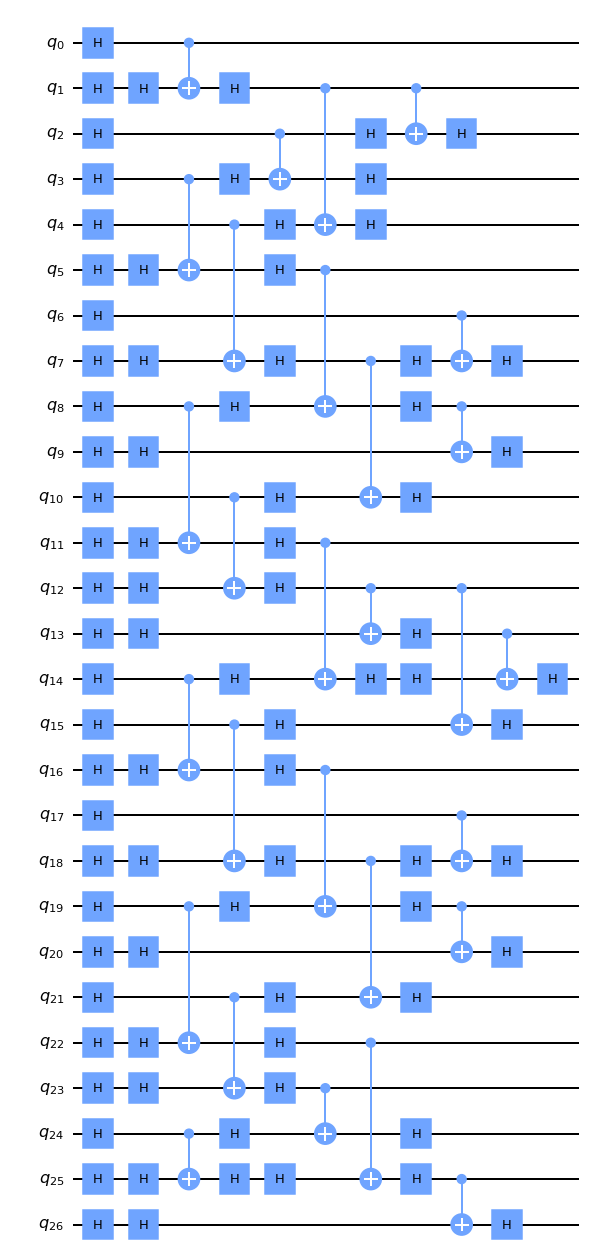

In [11]:
qc.draw("mpl")

In [12]:
base_type1 = [ 6, 17,
               0,  4, 10, 15, 21, 
               2, 13, 24,
               5, 11, 16, 22, 26,
               9, 20]
base_type2 = [ 1,  7, 12, 18, 23,
               3,  8, 14, 19, 25]
assert len(base_type1) == len(set(base_type1))
assert len(base_type2) == len(set(base_type2))
assert len(base_type1 + base_type2) == len(set(base_type1 + base_type2)) == size

In [13]:
qcs = prepare_connection_graph_qcs(qc, 
                                   base_type1, 
                                   base_type2, 
                                   backend = backend, 
                                   optimization_level = 1, 
                                   initial_layout = initial_layout)
print(len(qcs), "quantum circuits")

/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


4 quantum circuits


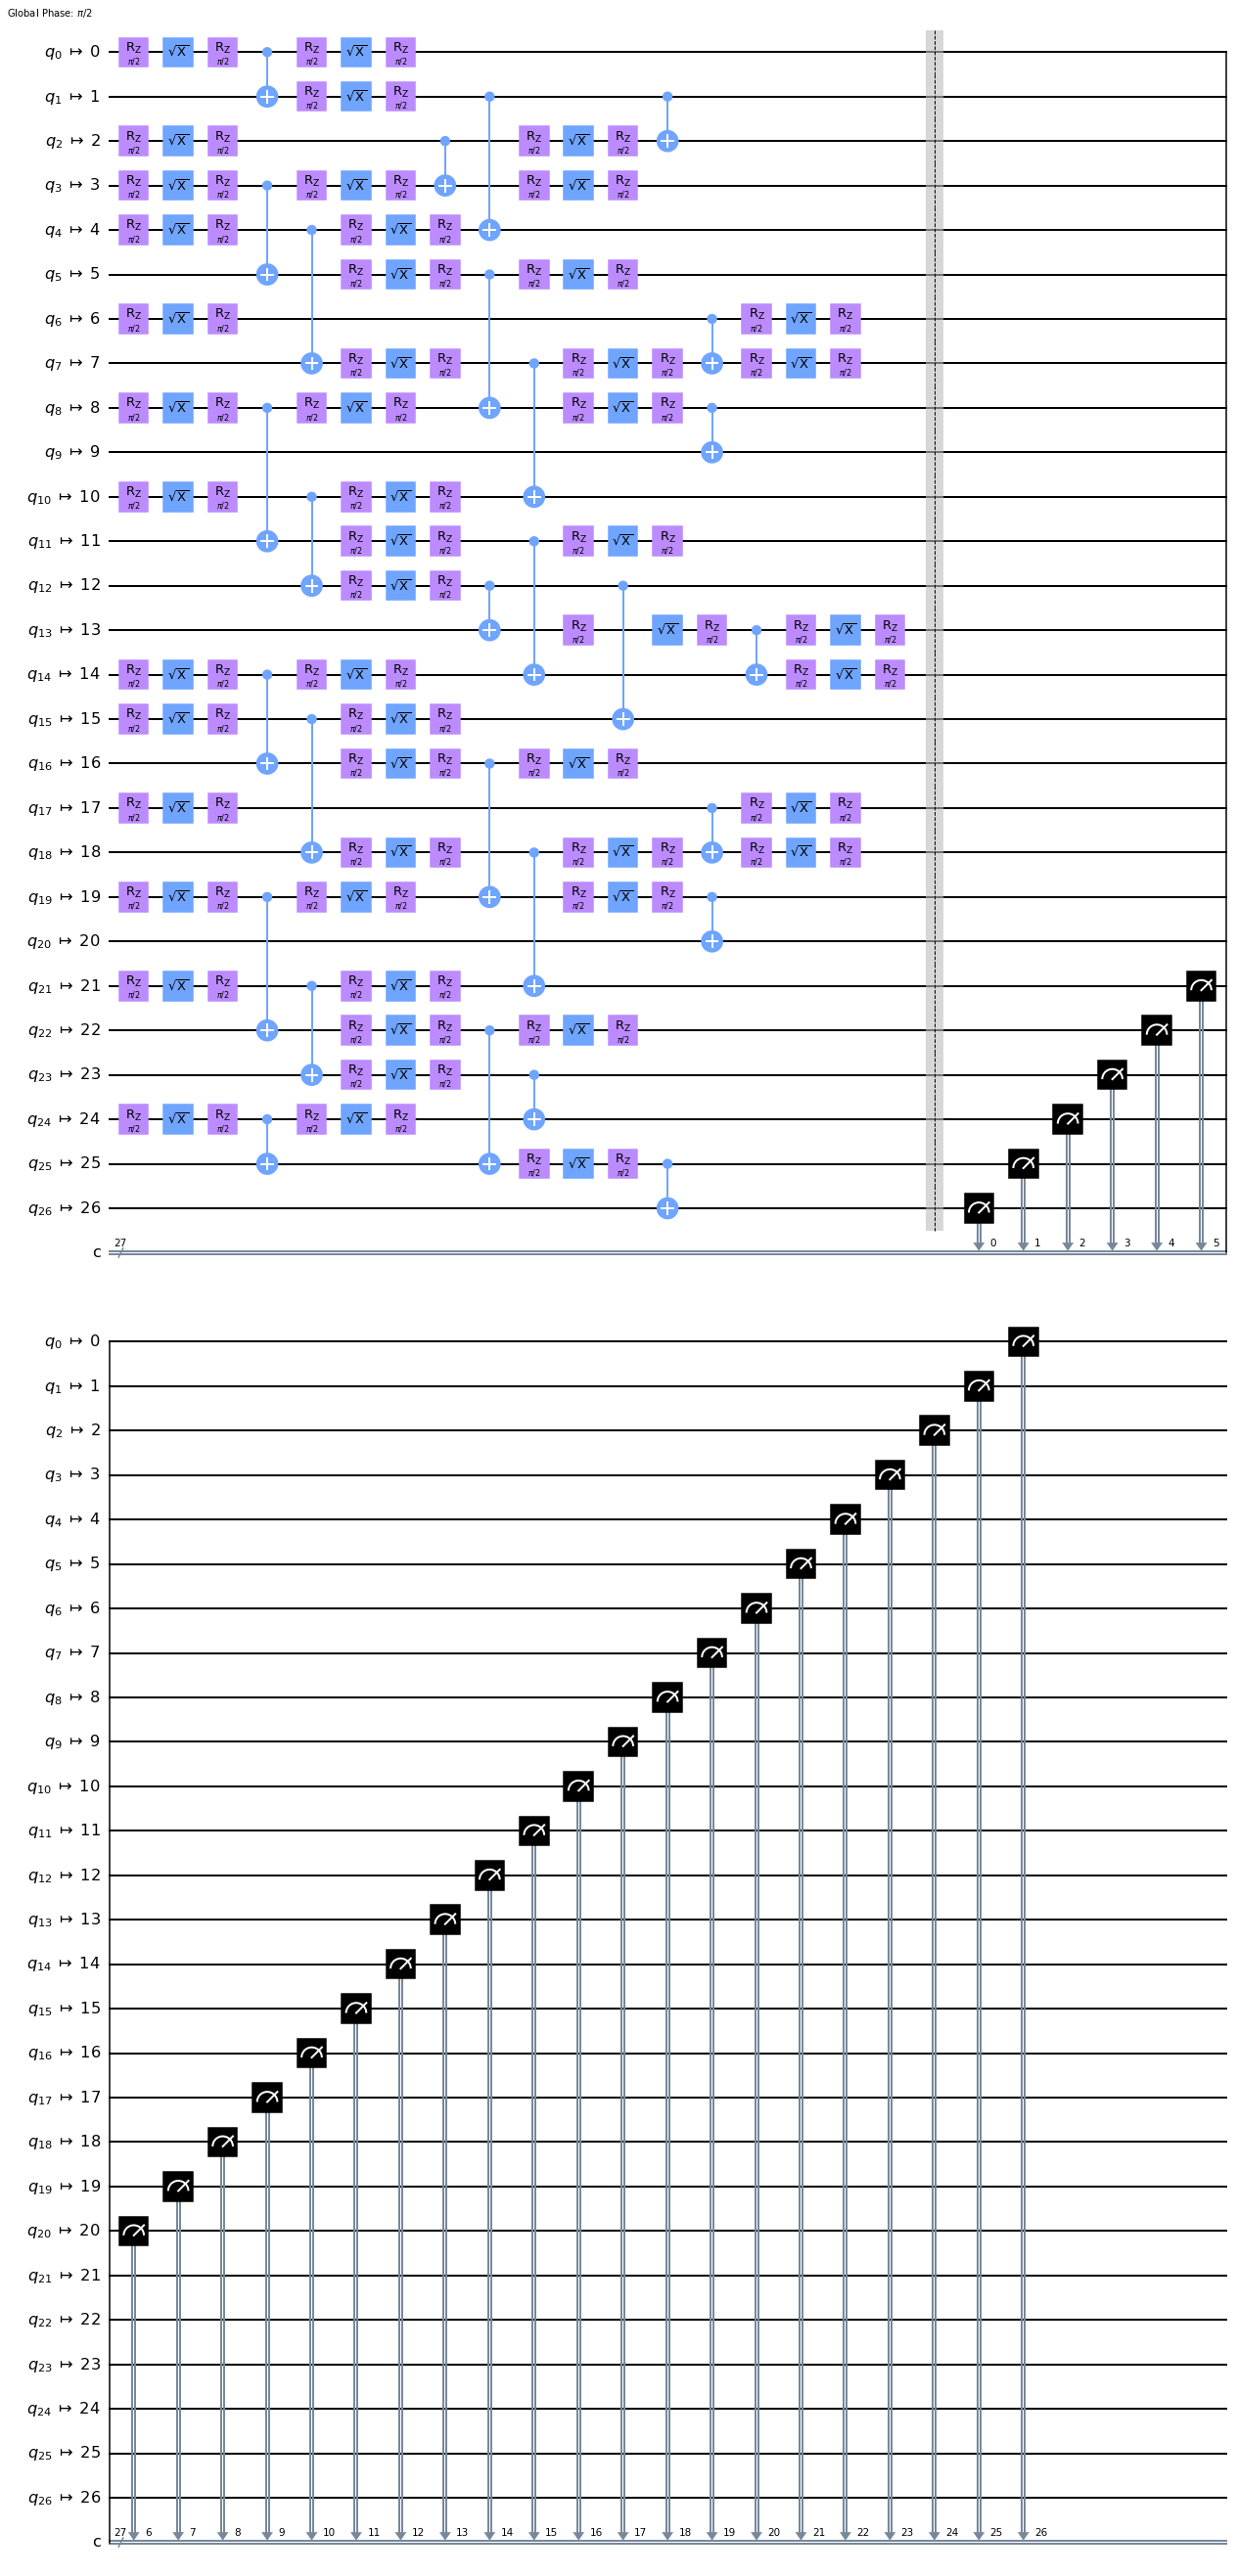

In [14]:
qcs[0].draw("mpl")

In [15]:
job = execute(qcs, backend = backend, shots=shots)
print(job.job_id())

61e346286113fa5bff5a8b09


In [16]:
dt_now = datetime.datetime.now()
job_id_filename = "job_id_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [17]:
with open("./pkls/" + job_id_filename, "wb") as f:
    pickle.dump(job.job_id(), f)

In [18]:
with open("./pkls/" + "properties_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

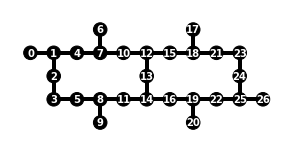

In [19]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)

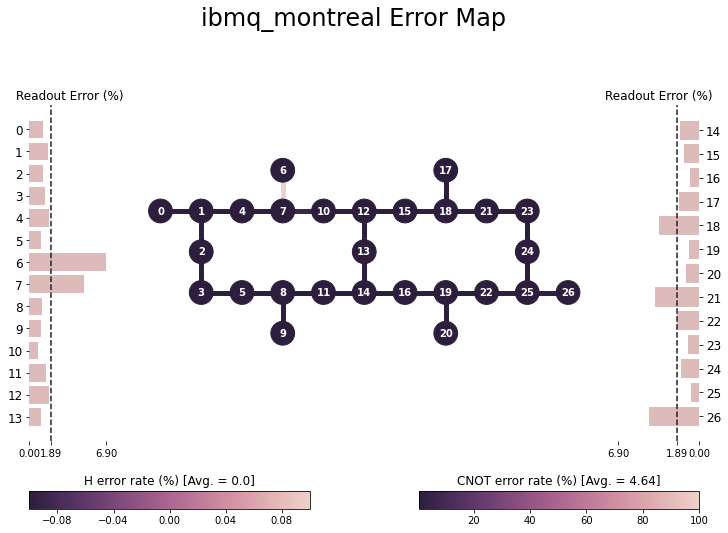

In [20]:
from qiskit.visualization import plot_error_map
plot_error_map(device)